## Background

You are developing an NGS-based assay for a recently characterized disorder called Deldupemia, an autosomal recessive disease caused by mutations in the CNSL gene. Due to high sequence homology in the CNSL region, deletions and duplications are common (thus, rather than all patients having two copies of DNA across the region, **some have one, and others have three**). The deletion/duplication breakpoints can vary from sample to sample (see table further below), and it has been **hypothesized that the breakpoints correspond with ethnicity**.

With help from someone on the molecular biology team, you developed probes for the CNSL region and performed a retrospective analysis of 10,000 Myriad Women’s Health samples spanning different ethnicities. The data in “cnsl_data.csv.gz” catalogs the depth of NGS reads at 100 different hybrid capture probe locations, 50 in the CNSL region, and 50 outside of the region. The depth at a probe is expected to be linearly proportional to the copy number of the DNA at that site (i.e., having three CNSL copies should give roughly 3x the depth as having one copy).

## Assumptions

- Probes in the “nonCNSL” region are expected to have CN=2.
- A deletion or duplication is any contiguous stretch of at least four well behaved probes
that have copy number of ~1 or ~3, respectively.
- Due to variability of extraction efficiency in the lab and error in the quantification of DNA
libraries, each sample has a slightly different average NGS read depth across all probes.
- Each probe captures DNA with different efficiency relative to other probes, but you can
assume that a single probe is equally efficient across all samples.
- The breakpoint positions are known in the literature and correspond to the following
probe locations
    - 32-38
    - 27-34
    - 20-40
    - 10-40


## Task

- Write code to characterize the deletion and duplication frequencies and breakpoint positions on a per-ethnicity basis. 
- Your algorithm for finding deletions and duplications may use hardcoded breakpoints based on the table above, or be general. 
- Help the lab identify any problematic probes that may need redesigning.

## Steps

### 1. Data Loading and Exploration


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
cnsl_data = pd.read_csv('cnsl_data.csv.gz', index_col=[0])

In [3]:
cnsl_data

,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_5,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,...,non_CNSL_probe_40,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49
0,A,410,233,697,167,131,77,520,132,161,...,578,186,232,1202,260,602,236,179,592,415
1,C,557,304,956,208,138,106,678,173,218,...,789,178,322,1630,314,780,334,218,708,582
2,A,487,260,861,194,148,94,617,191,205,...,761,205,335,1440,287,744,297,211,694,520
3,B,686,368,1276,267,221,1114,884,206,273,...,1035,309,415,2109,375,1008,441,315,1042,692
4,C,677,348,1248,267,179,268,856,225,305,...,947,252,385,1949,362,986,392,299,881,673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,A,523,292,942,215,141,48,634,172,217,...,752,213,282,1456,292,680,297,243,717,521
9996,A,1036,496,1883,364,313,81,1313,331,378,...,1447,418,581,3017,581,1484,637,397,1407,1083
9997,C,847,430,1541,368,250,719,1026,306,340,...,1237,308,455,2577,489,1277,551,374,1247,874
9998,B,1013,606,1819,434,306,29,1281,382,455,...,1406,422,597,3117,592,1451,601,478,1458,1015


In [4]:
# check column names
list(cnsl_data)

['ethnicity',
 'CNSL_probe_0',
 'CNSL_probe_1',
 'CNSL_probe_2',
 'CNSL_probe_3',
 'CNSL_probe_4',
 'CNSL_probe_5',
 'CNSL_probe_6',
 'CNSL_probe_7',
 'CNSL_probe_8',
 'CNSL_probe_9',
 'CNSL_probe_10',
 'CNSL_probe_11',
 'CNSL_probe_12',
 'CNSL_probe_13',
 'CNSL_probe_14',
 'CNSL_probe_15',
 'CNSL_probe_16',
 'CNSL_probe_17',
 'CNSL_probe_18',
 'CNSL_probe_19',
 'CNSL_probe_20',
 'CNSL_probe_21',
 'CNSL_probe_22',
 'CNSL_probe_23',
 'CNSL_probe_24',
 'CNSL_probe_25',
 'CNSL_probe_26',
 'CNSL_probe_27',
 'CNSL_probe_28',
 'CNSL_probe_29',
 'CNSL_probe_30',
 'CNSL_probe_31',
 'CNSL_probe_32',
 'CNSL_probe_33',
 'CNSL_probe_34',
 'CNSL_probe_35',
 'CNSL_probe_36',
 'CNSL_probe_37',
 'CNSL_probe_38',
 'CNSL_probe_39',
 'CNSL_probe_40',
 'CNSL_probe_41',
 'CNSL_probe_42',
 'CNSL_probe_43',
 'CNSL_probe_44',
 'CNSL_probe_45',
 'CNSL_probe_46',
 'CNSL_probe_47',
 'CNSL_probe_48',
 'CNSL_probe_49',
 'non_CNSL_probe_0',
 'non_CNSL_probe_1',
 'non_CNSL_probe_2',
 'non_CNSL_probe_3',
 'non_CNSL_p

In [5]:
# distribution of ethnicity
cnsl_data.ethnicity.value_counts()

A    4988
B    2543
C    2469
Name: ethnicity, dtype: int64

First, let's do some brief visualization to get a general idea about the data.

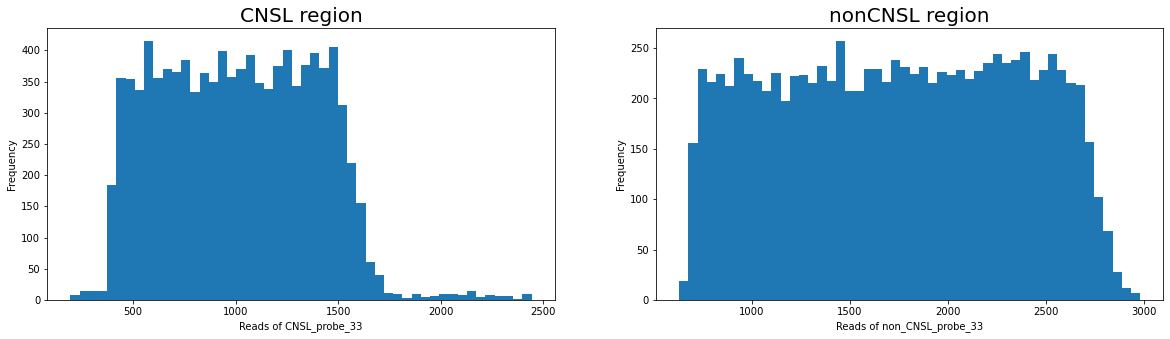

In [6]:
# get a general idea of the distribution of the reads for a certain probe
def hist_plot_probe(data, CNSL_probe, nonCNSL_probe):

    plt.figure(figsize = [20, 5]) 

    ax1 = plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 1
    # for the distribution of the reads for a random probe in the CNSL region
    plt.hist(data[CNSL_probe], bins = 50);
    plt.xlabel("Reads of " + CNSL_probe);
    plt.ylabel("Frequency");
    ax1.set_title('CNSL region', fontsize=20);

    ax2 = plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
    # for the distribution of the reads for a random probe in the nonCNSL region
    plt.hist(data[nonCNSL_probe], bins = 50);
    plt.xlabel("Reads of " + nonCNSL_probe);
    plt.ylabel("Frequency");
    ax2.set_title('nonCNSL region', fontsize=20);


hist_plot_probe(cnsl_data, 'CNSL_probe_33', 'non_CNSL_probe_33')

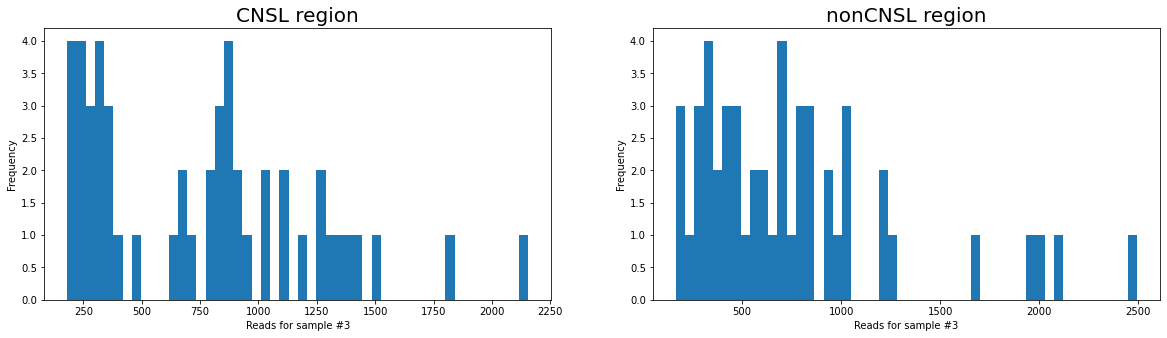

In [7]:
# get a general idea of the distribution of the reads for a certain sample

def hist_plot_sample(data, sample_id):

    plt.figure(figsize = [20, 5]) 

    ax1 = plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
    # for the distribution of the CNSL region reads of a sample (#3)
    plt.hist(data.iloc[sample_id, 1:51], bins = 50);
    plt.xlabel("Reads for sample #" + str(sample_id));
    plt.ylabel("Frequency");
    ax1.set_title('CNSL region', fontsize=20);

    ax2 = plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
    # for the distribution of the nonCNSL region reads of a sample (#3)
    plt.hist(data.iloc[sample_id, 51:], bins = 50);
    plt.xlabel("Reads for sample #" + str(sample_id));
    plt.ylabel("Frequency");
    ax2.set_title('nonCNSL region', fontsize=20);

hist_plot_sample(cnsl_data, 3)

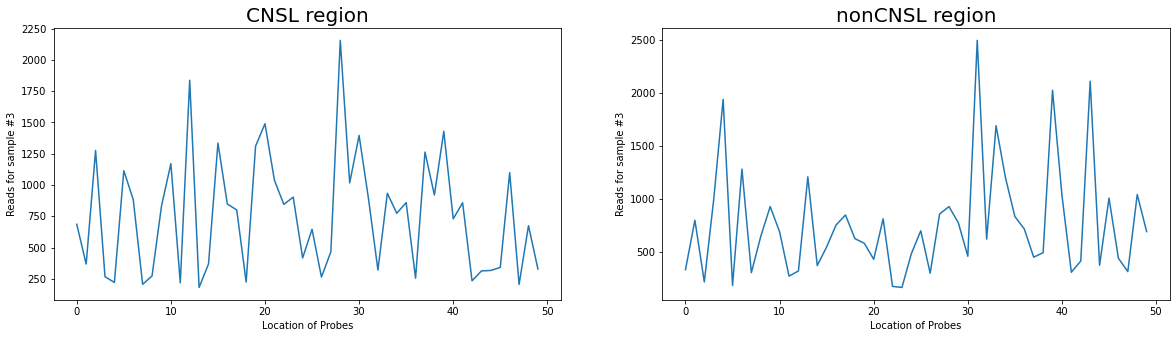

In [8]:
# line chart for a particular sample
def line_chart_sample(data, sample_id):

    plt.figure(figsize = [20, 5]) 

    ax1 = plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
    # for the distribution of the CNSL region reads of a sample
    plt.errorbar(x = np.arange(50), y = data.iloc[sample_id, 1:51]);
    plt.xlabel("Location of Probes");
    plt.ylabel("Reads for sample #" + str(sample_id));
    ax1.set_title('CNSL region', fontsize=20);

    ax2 = plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
    # for the distribution of the nonCNSL region reads of a sample
    plt.errorbar(x = np.arange(50), y = data.iloc[sample_id, 51:]);
    plt.xlabel("Location of Probes");
    plt.ylabel("Reads for sample #" + str(sample_id));
    ax2.set_title('nonCNSL region', fontsize=20);

line_chart_sample(cnsl_data, 3)


### 2. Sample Normalization

- Because each sample has different average NGS read depth across all probes, and probes in the “nonCNSL” region are expected to have CN=2, we can use the read depth of the "nonCNSL" region to normalize all samples.
- For each sample, the reads will be divided by the average of the reads for all of the probes on the nonCNSL gene region.

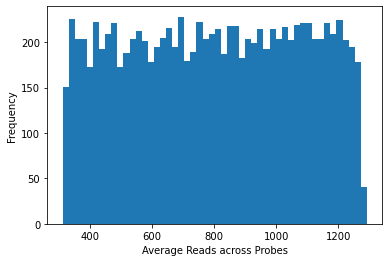

In [9]:
# the average of reads across all probes within the nonCNSL region for each sample
sample_normalization_factor = np.mean(cnsl_data[list(cnsl_data)[51:]], axis = 1)
plt.hist(sample_normalization_factor, bins = 50);
plt.xlabel("Average Reads across Probes");
plt.ylabel("Frequency");

In [10]:
# cnsl data: sample normalization
cnsl_s_norm = cnsl_data.copy()
cnsl_s_norm.iloc[:,1:] = cnsl_s_norm.iloc[:,1:].div(sample_normalization_factor, axis = 0)

Let's check the data after the sample normalization:

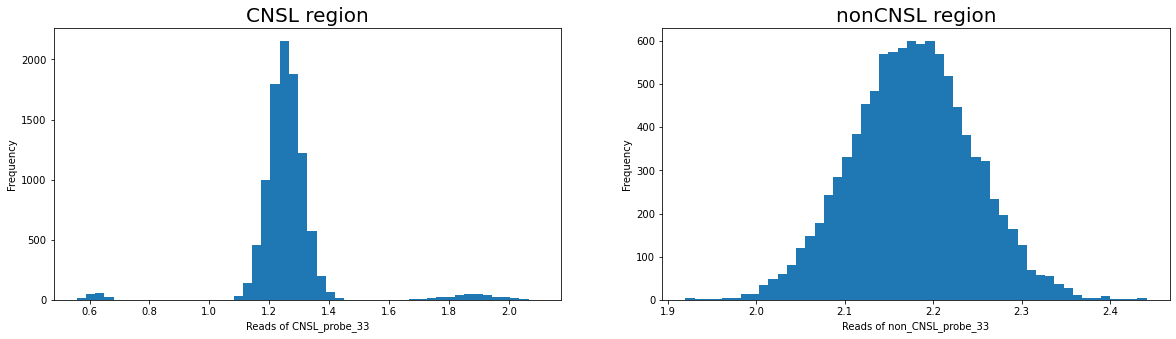

In [11]:
# after sample normalization
# get a general idea of the distribution of the reads for a particular probe
hist_plot_probe(cnsl_s_norm, 'CNSL_probe_33', 'non_CNSL_probe_33')

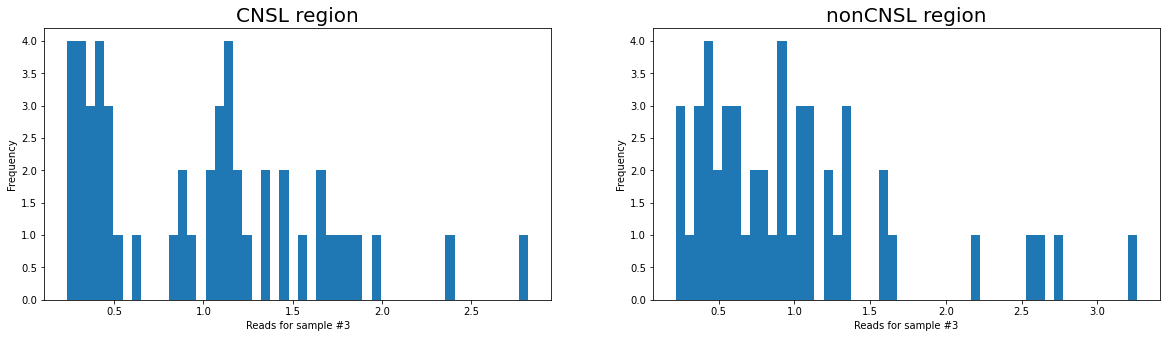

In [12]:
# after normalization
# get a general idea of the distribution of the reads for a particular sample
hist_plot_sample(cnsl_s_norm, 3)

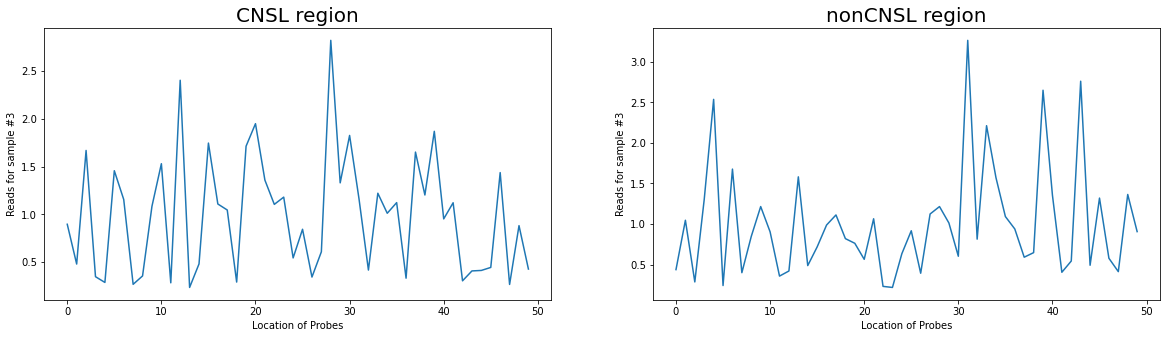

In [13]:
# line chart after sample normalization for a particular sample
line_chart_sample(cnsl_s_norm, 3)

Note that after sample normalization, the distributions of a certain probe across all samples look much nicer! However, the signal of all probes for a certain sample is still very noisy! This is because different probes have different efficiency. Next, we will normalize the data by probes.

### 3. Probe Normalization

For each probe, the reads of all samples will be divided by the average of the reads for all of the samples for that particular probe. The assumption for the probe normalization is that the average reads for different probes are not affected by whether that probe happens to be in a region of deletion or duplication. Given that the overall deletion or duplication frequency is not high, plus the fact deletion and duplication will have opposite effect on the signal and thus cancel out each other, we should be able to perform probe normalization this way. After this normalization, the ratio of 1 will indicate CN = 2. Then a ratio of 0.5 indicates a deletion (CN = 1), and a ratio of 1.5 indicates a duplication (CN = 3).

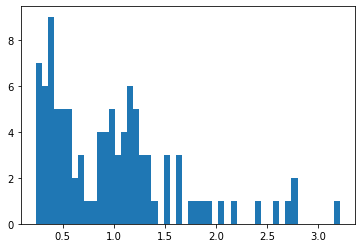

In [14]:
# the average of reads across all samples within the nonCNSL region for each probe
probe_normalization_factor = np.mean(cnsl_s_norm[list(cnsl_s_norm)[1:]], axis = 0)
plt.hist(probe_normalization_factor, bins = 50);

In [15]:
cnsl_s_p_norm = cnsl_s_norm.copy()
cnsl_s_p_norm.iloc[:,1:] = cnsl_s_p_norm.iloc[:,1:].div(probe_normalization_factor, axis = 1)

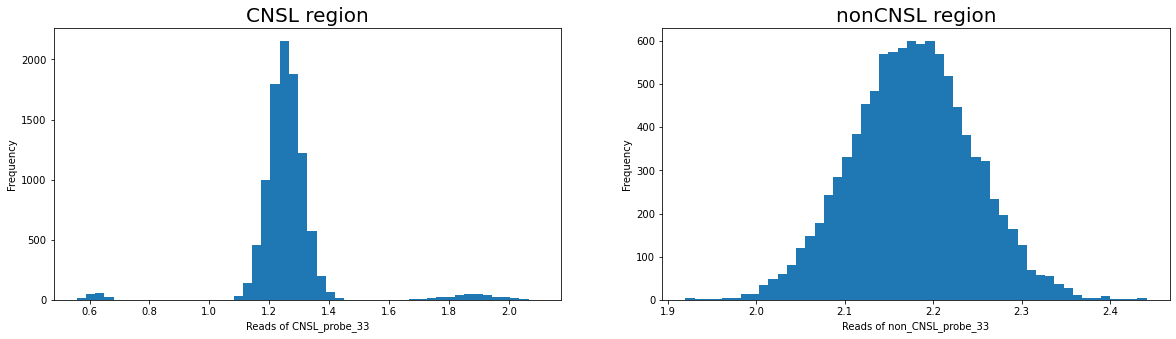

In [16]:
# after probe normalization
# get a general idea of the distribution of the reads for a particular probe
# note that the normalized reads center at 1 now
hist_plot_probe(cnsl_s_norm, 'CNSL_probe_33', 'non_CNSL_probe_33')

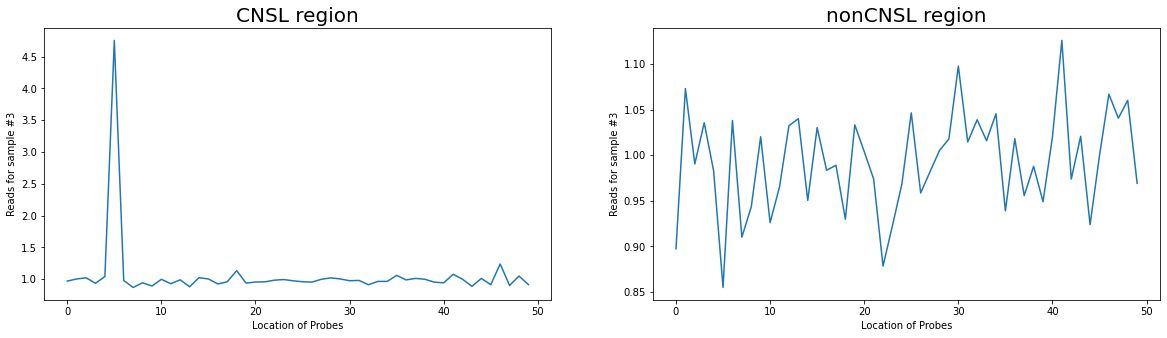

In [17]:
# line chart after probe normalization for a particular sample
line_chart_sample(cnsl_s_p_norm, 3)

### 4. Remove Problematic Probes

Note in the above plot there is a huge peak for one of the probes, indicating that some probes might have unusual behaviors. Let's check the variability of all probes.

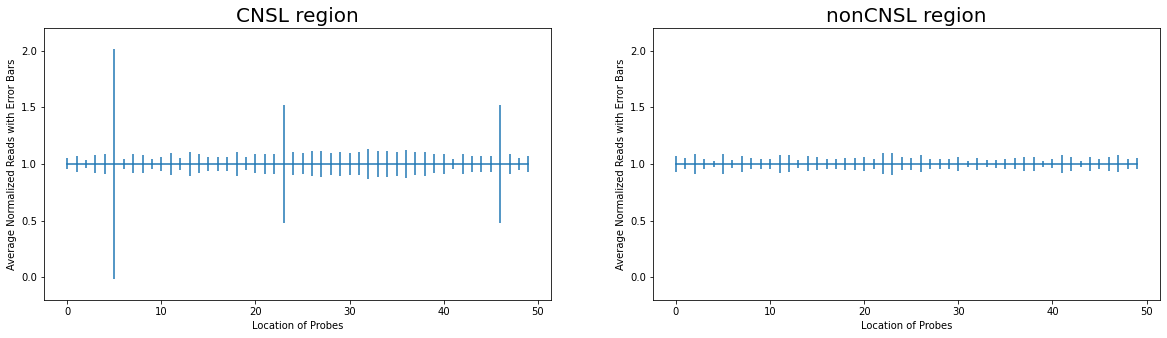

In [18]:
# after sample and probe normalization
plt.figure(figsize = [20, 5]) 

ax1 = plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
y_mean = np.mean(cnsl_s_p_norm.iloc[:, 1:51], axis = 0)
y_std = np.std(cnsl_s_p_norm.iloc[:, 1:51], axis = 0)
plt.errorbar(x=np.arange(50), y=y_mean, yerr=y_std);
plt.ylim([-0.2, 2.2]);
plt.xlabel("Location of Probes");
plt.ylabel("Average Normalized Reads with Error Bars");
ax1.set_title('CNSL region', fontsize=20);

ax2 = plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
# for the distribution of the CNSL region reads of a sample
y_mean = np.mean(cnsl_s_p_norm.iloc[:, 51:], axis = 0)
y_std = np.std(cnsl_s_p_norm.iloc[:, 51:], axis = 0)
plt.errorbar(x=np.arange(50), y=y_mean, yerr=y_std);
plt.ylim([-0.2, 2.2]);
plt.xlabel("Location of Probes");
plt.ylabel("Average Normalized Reads with Error Bars");
ax2.set_title('nonCNSL region', fontsize=20);


We can see that some of the probes in the CNSL gene region have super high variation which might interfere the calling of duplications or deletions. So we need to remove these probematic probes.

In [19]:
# find out the bad probes are: CNSL_probe_5, _23, _46
# set an artificial threshold for the variation
cnsl_std = np.std(cnsl_s_p_norm.iloc[:, 1:51], axis = 0) 
(cnsl_std[cnsl_std > 0.2]).index

Index(['CNSL_probe_5', 'CNSL_probe_23', 'CNSL_probe_46'], dtype='object')

In [20]:
# drop the problematic probes
bad_prob_ind = np.where(cnsl_std > 0.2)
cnsl_clean = cnsl_s_p_norm.drop((cnsl_std[cnsl_std > 0.2]).index, axis = 1)

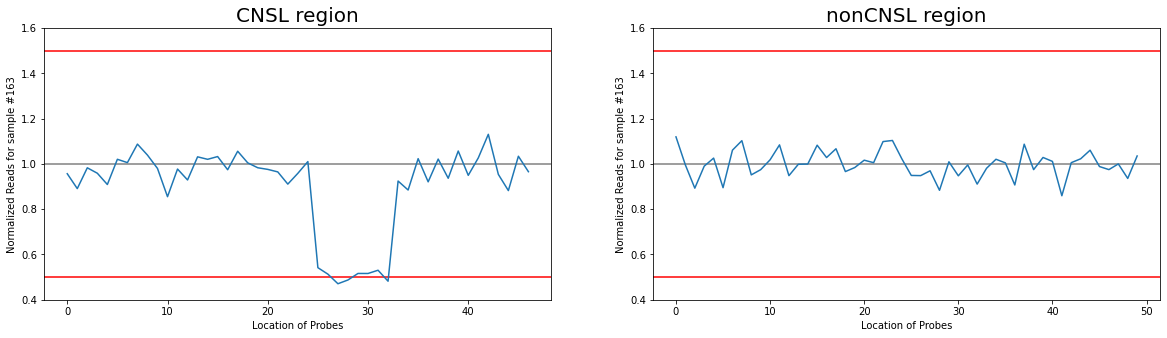

In [21]:
# line chart after normalization for a particular sample
def check_sample(data, sample_id):

    plt.figure(figsize = [20, 5]) 

    ax1 = plt.subplot(1, 2, 1)# 1 row, 2 cols, subplot 2
    # for the distribution of the CNSL region reads of a sample
    plt.errorbar(x = np.arange(47), y = data.iloc[sample_id, 1:48]);
    plt.ylim([0.4, 1.6]);
    plt.axhline(y = 1, color = 'grey');
    plt.axhline(y = 1.5, color = 'red');
    plt.axhline(y = 0.5, color = 'red');    
    plt.xlabel("Location of Probes");
    plt.ylabel("Normalized Reads for sample #" + str(sample_id));
    ax1.set_title('CNSL region', fontsize=20);    

    ax2 = plt.subplot(1, 2, 2)# 1 row, 2 cols, subplot 2
    # for the distribution of the nonCNSL region reads of a sample
    plt.errorbar(x = np.arange(50), y = data.iloc[sample_id, 48:]);
    plt.ylim([0.4, 1.6]);
    plt.axhline(y = 1, color = 'grey');
    plt.axhline(y = 1.5, color = 'red');
    plt.axhline(y = 0.5, color = 'red');
    plt.xlabel("Location of Probes");
    plt.ylabel("Normalized Reads for sample #" + str(sample_id));
    ax2.set_title('nonCNSL region', fontsize=20);

check_sample(cnsl_clean, 163)

### 5. Deletion/Duplication Annotation

Next, we can write a function to call out the duplications and deletions.
- The breakpoint positions are known in the literature and correspond to the following probe locations:
    - 10-40
    - 20-40
    - 27-34
    - 32-38

- For each sample, we will call the `variation_calling` function. We pass the normalized data (note that we don't use the *cleaned* data just because it's more convinient to work on the dataset with all probes in it). 
- We then extract the signal array of all probes within the CSNL gene region, and pass it to a helper function `check_breakpoint`, along with the range of each breakpoint pair that we want to check.
- For a certain array of signal, and a range of the breakpoint (defined by an upperbound an lowerbound), we first filter out the "bad" probes using probe index. Then we calculate the average signal value of that range. We artificially define a threshold here to call out a variation. For example, 1.35 - 1.65 will indicate duplication, and 0.35 - 0.65 will indicate a deletion. This is based on our earlier observations of the data.
- Also note that the order we check the breakpoints does matter because some of the ranges are nested. For example, a deletion of 10-40 might also be called out as a deletion of 32-38. So we check the largest range first and will immediately return if there is a hit.
- Next, we add a new column to the `cnsl_clean` file to include the annnotations.

In [22]:
def variation_calling(data, sample_id):
    signal_array = data.iloc[sample_id, 1:51]
    result = check_breakpoint(signal_array, 10, 40)
    if result:
        return result + "_10"
    result = check_breakpoint(signal_array, 20, 40)
    if result:
        return result + "_20"    
    result = check_breakpoint(signal_array, 27, 34)
    if result:
        return result + "_27" 
    result = check_breakpoint(signal_array, 32, 38)
    if result:
        return result + "_32" 
    return "wt"
    
    
def check_breakpoint(signal_array, u, d):
    ind = np.setdiff1d(np.arange(u, d+1), bad_prob_ind)
    signal_mean = np.mean(signal_array[ind])
    if abs(signal_mean - 1.5) < 0.15:
        return "duplication"
    elif abs(signal_mean - 0.5) < 0.15:
        return "deletion"
    else:
        return

# test the function:
variation_calling(cnsl_s_p_norm, 234)

'deletion_20'

In [23]:
annotation = []
for i in range(cnsl_s_p_norm.shape[0]):
    annotation.append(variation_calling(cnsl_s_p_norm, i))
cnsl_clean["annotation"] = annotation

In [24]:
cnsl_clean

,ethnicity,CNSL_probe_0,CNSL_probe_1,CNSL_probe_2,CNSL_probe_3,CNSL_probe_4,CNSL_probe_6,CNSL_probe_7,CNSL_probe_8,CNSL_probe_9,...,non_CNSL_probe_41,non_CNSL_probe_42,non_CNSL_probe_43,non_CNSL_probe_44,non_CNSL_probe_45,non_CNSL_probe_46,non_CNSL_probe_47,non_CNSL_probe_48,non_CNSL_probe_49,annotation
0,A,0.997094,1.093492,0.959974,1.007345,1.062555,0.991478,0.959378,0.956826,1.026968,...,1.164922,0.935729,0.999863,1.100977,1.026147,0.981381,1.016348,1.035255,0.998972,wt
1,C,1.035410,1.090531,1.006444,0.959025,0.855587,0.988130,0.961096,0.990304,1.015531,...,0.852136,0.992711,1.036402,1.016341,1.016279,1.061640,0.946130,0.946376,1.070861,wt
2,A,0.937088,0.965455,0.938272,0.925897,0.949819,0.930816,1.098369,0.963962,1.014603,...,1.015867,1.069069,0.947758,0.961581,1.003426,0.977195,0.947919,0.960249,0.990393,wt
3,B,0.970717,1.004902,1.022571,0.937107,1.043010,0.980727,0.871163,0.944030,0.893630,...,1.126052,0.973926,1.020772,0.923958,0.999746,1.067039,1.040677,1.060252,0.969231,wt
4,C,1.021364,1.013161,1.066303,0.999108,0.900684,1.012495,1.014467,1.124467,0.967678,...,0.979093,0.963301,1.005744,0.950939,1.042629,1.011233,1.053174,0.955742,1.004985,wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,A,1.012848,1.091271,1.033161,1.032739,0.910730,0.962629,0.995485,1.026969,0.948943,...,1.062316,0.905735,0.964468,0.984641,0.923023,0.983496,1.098717,0.998470,0.998695,wt
9996,A,1.007804,0.931119,1.037387,0.878268,1.015520,1.001402,0.962294,0.898593,1.050292,...,1.047187,0.937350,1.003865,0.984113,1.011838,1.059569,0.901662,0.984200,1.042791,wt
9997,C,0.982842,0.962888,1.012691,1.059149,0.967537,0.933415,1.061170,0.964126,0.963244,...,0.920412,0.875631,1.022817,0.988010,1.038608,1.093264,1.013232,1.040494,1.003839,wt
9998,B,0.981773,1.133396,0.998409,1.043280,0.989124,0.973370,1.106442,1.077626,1.053031,...,1.053285,0.959590,1.033290,0.999024,0.985667,0.995978,1.081600,1.016090,0.973689,wt


In [25]:
cnsl_clean["annotation"].value_counts()

wt                9523
duplication_20     125
duplication_10      76
duplication_32      63
duplication_27      61
deletion_32         57
deletion_27         55
deletion_20         25
deletion_10         15
Name: annotation, dtype: int64

### 6. Summarize the Annotations

At the end, we summarize the annotations by ethnicity. Note now we have 9 different annotations because we differentiate deletions and duplications. Later we also aggregate these two different forms of variation for each breakpoint. We use Pandas functionalities to summarize the data and calculate frequencies according to observation numbers of each genotype and total sample size of each ethnicity group.

In [26]:
# further process the data to summarize the annotations according to ethnicity groups
ethnicity_variation = cnsl_clean[["ethnicity", "annotation"]]
annotation_by_ethnicity = ethnicity_variation.groupby(["ethnicity", "annotation"]).size().reset_index(name='counts')
ethnicity_counts = cnsl_data.ethnicity.value_counts().reset_index(name='total_counts').rename(columns = {"index": "ethnicity"})
annotation_by_ethnicity = pd.merge(annotation_by_ethnicity, ethnicity_counts, how = "left", on = "ethnicity")
annotation_by_ethnicity["frequency"] = annotation_by_ethnicity.counts/annotation_by_ethnicity.total_counts
breakpoint_by_ethnicity = annotation_by_ethnicity.replace(["deletion", "duplication"], "breakpoint", regex = True)
breakpoint_by_ethnicity = breakpoint_by_ethnicity.groupby(["ethnicity","annotation"]).agg({'counts':'sum','total_counts':'mean', 'frequency':'sum'}).reset_index()


In [27]:
annotation_by_ethnicity

,ethnicity,annotation,counts,total_counts,frequency
0,A,deletion_27,55,4988,0.011026
1,A,deletion_32,57,4988,0.011427
2,A,duplication_27,61,4988,0.012229
3,A,duplication_32,63,4988,0.012630
4,A,wt,4752,4988,0.952686
5,B,deletion_10,1,2543,0.000393
6,B,deletion_20,25,2543,0.009831
7,B,duplication_10,7,2543,0.002753
8,B,duplication_20,125,2543,0.049155
9,B,wt,2385,2543,0.937869


In [28]:
breakpoint_by_ethnicity

,ethnicity,annotation,counts,total_counts,frequency
0,A,breakpoint_27,116,4988,0.023256
1,A,breakpoint_32,120,4988,0.024058
2,A,wt,4752,4988,0.952686
3,B,breakpoint_10,8,2543,0.003146
4,B,breakpoint_20,150,2543,0.058985
5,B,wt,2385,2543,0.937869
6,C,breakpoint_10,83,2469,0.033617
7,C,wt,2386,2469,0.966383


In [29]:
# save output files
cnsl_clean.to_csv("cnsl_annotation.csv", index = False)
annotation_by_ethnicity.to_csv("cnsl_annotation_by_ethnicity.csv", index = False)
breakpoint_by_ethnicity.to_csv("cnsl_breakpoint_by_ethnicity.csv", index = False)